<a href="https://colab.research.google.com/github/jaiakash03/codesoft/blob/main/movie_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving IMDb Movies India.csv to IMDb Movies India (8).csv


Saving IMDb Movies India.csv to IMDb Movies India (9).csv
Index(['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3'],
      dtype='object')
Mean Squared Error: 1.77
Root Mean Squared Error: 1.33
R² Score: 0.05


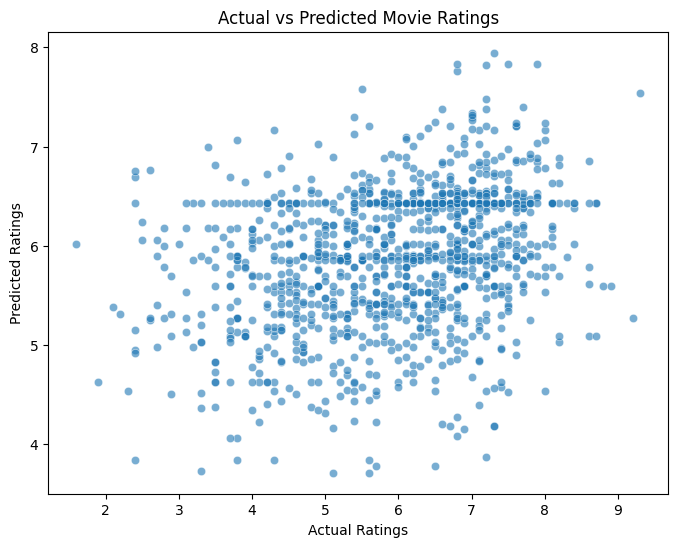

In [ ]:
from google.colab import files
uploaded = files.upload()
# Install any missing libraries (optional, Colab already has most)
!pip install scikit-learn pandas matplotlib seaborn

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Upload your CSV file via Colab's file uploader
from google.colab import files
uploaded = files.upload()

# Load the CSV
df = pd.read_csv('/content/IMDb Movies India.csv', encoding='latin-1')  # replace with your file name
df.head()
# Check columns
print(df.columns)

# Let's keep useful columns only and drop rows with missing values
df = df[['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']].dropna()


# Combine actor columns into a single 'actors' column
df['actors'] = df['Actor 1'].fillna('') + ', ' + df['Actor 2'].fillna('') + ', ' + df['Actor 3'].fillna('')
df['actors'] = df['actors'].apply(lambda x: [actor.strip() for actor in x.split(',') if actor.strip()])

# Convert genre to list
df['Genre'] = df['Genre'].apply(lambda x: x.split(', '))

# Use MultiLabelBinarizer for genres
genre_mlb = MultiLabelBinarizer()
genre_encoded = genre_mlb.fit_transform(df['Genre'])
genre_df = pd.DataFrame(genre_encoded, columns=genre_mlb.classes_, index=df.index) # Keep original index

# Use top 20 actors only
from collections import Counter
actor_counts = Counter([actor for sublist in df['actors'] for actor in sublist])
top_actors = [actor for actor, count in actor_counts.most_common(20)]

# Create binary features for top actors
for actor in top_actors:
    df[f'actor_{actor}'] = df['actors'].apply(lambda x: 1 if actor in x else 0)

# Use top 10 directors
top_directors = df['Director'].value_counts().nlargest(10).index.tolist()
df['Director'] = df['Director'].apply(lambda x: x if x in top_directors else 'Other')

# One-hot encode directors
director_dummies = pd.get_dummies(df['Director'], prefix='director') # Keep original index

# Combine all features
X = pd.concat([genre_df, df[[f'actor_{a}' for a in top_actors]], director_dummies], axis=1)
y = df['Rating']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
# Plot true vs predicted ratings
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Movie Ratings")
plt.show()